<a href="https://colab.research.google.com/github/DinisMartinho/Eye-Diseases-Classification/blob/main/Colab%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Link to the dataset: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
# This model is capable of classifying Retinal OCT images
# within one of these classes with high accuracy:
# ["DRUSEN", "CNV", "DME", "NORMAL"]

In [1]:
!pip install opendatasets --upgrade --quiet 
import torch, torchvision, matplotlib.pyplot, opendatasets, math

In [2]:
# GPU is necessary to run this notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

In [ ]:
# Download our dataset from Kaggle.
opendatasets.download("https://www.kaggle.com/datasets/paultimothymooney/kermany2018")

In [5]:
# Define the differente classes inside our dataset.
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

In [110]:
# Set the augmentations we are going to apply to our "raw" data.
norm_factors = (0.5), (0.5)

transforms = [
              torchvision.transforms.Grayscale(),
              torchvision.transforms.Resize(256),
              torchvision.transforms.CenterCrop((256, 256)),
              torchvision.transforms.RandomHorizontalFlip(p=0.5),
              torchvision.transforms.RandomVerticalFlip(p=0.5),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(norm_factors[0], norm_factors[1])
              ]

In [109]:
# Create our testing, training and validation datasets and data loaders.
batch_size = 32

Train_dataset = torchvision.datasets.ImageFolder("./kermany2018/OCT2017 /train", transform=torchvision.transforms.Compose(transforms))
Validation_dataset = torchvision.datasets.ImageFolder("./kermany2018/OCT2017 /val", transform=torchvision.transforms.Compose(transforms))
Testing_dataset = torchvision.datasets.ImageFolder("./kermany2018/OCT2017 /test", transform=torchvision.transforms.Compose(transforms))

training_data_loader = torch.utils.data.DataLoader(Train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(Validation_dataset, batch_size=batch_size*2, num_workers=2, shuffle=True)
testing_data_loader = torch.utils.data.DataLoader(Testing_dataset, batch_size=batch_size*2, num_workers=2, shuffle=True)

In [95]:
# Let's create a function to allow us to easily display a batch of data.
def show_batch(dl):
  for batch in dl:
      images, labels = batch
      fig, ax = matplotlib.pyplot.subplots(figsize=(12, 6))
      ax.set_xticks([]); ax.set_yticks([])
      images = images.repeat(1, 3, 1, 1)
      ax.imshow(torchvision.utils.make_grid(images * norm_factors[1] + norm_factors[0], nrow=8).permute(1, 2, 0))
      break

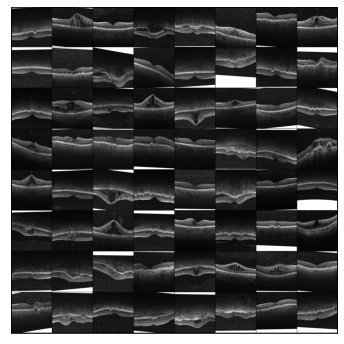

In [64]:
show_batch(testing_data_loader)

In [66]:
# Each image is labeled with one of these classes: 
# ["DRUSEN", "CNV", "DME", "NORMAL"]

In [65]:
# Now let's create a simple deep convolutional neural network (DCNN),
# capable of correctly learning from our data. This network has a total of
# four possible outputs. -> ["DRUSEN", "CNV", "DME", "NORMAL"]

class DCNN(torch.nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()

        conv_layers = []
        in_channels = 1
        out_channels = 16
        for _ in range(6):
            conv_layers += [
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.LeakyReLU(0.2),
            ]
            in_channels = out_channels
            out_channels *= 2
            conv_layers.append(torch.nn.MaxPool2d(2, 2))

        conv_layers += [
            torch.nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.MaxPool2d(2, 2)
        ]

        conv_layers.append(torch.nn.Flatten())

        self.conv = torch.nn.Sequential(*conv_layers)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1024, 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [67]:
model = DCNN().to(device)

In [118]:
# Hyperparameters
num_epochs = 3 # Three to five epochs required to achieve 100% accuracy.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [119]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [120]:
# Let's create and run our training loop.
model.train()

total_samples = len(Train_dataset)
total_step = math.ceil(total_samples / batch_size)

for epoch in range(num_epochs):
  for i, (images, labels) in (enumerate(training_data_loader)):
    
    outputs = model(images.to(device))
    loss = loss_fn(outputs, labels.to(device))
        
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Print the loss for this epoch.
  print ('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  # Validate the model with our validation dataset.
  with torch.no_grad():
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(validation_data_loader):
          outputs = model(images.to(device))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.to(device)).sum().item()

      accuracy = 100 * (correct / total)
      print('Validation Accuracy: {:.2f}%'.format(accuracy))

Epoch [1/3], Batch [2609/2609], Loss: 0.2385
Validation Accuracy: 100.00%
Epoch [2/3], Batch [2609/2609], Loss: 0.0837
Validation Accuracy: 100.00%
Epoch [3/3], Batch [2609/2609], Loss: 0.4371
Validation Accuracy: 100.00%


In [121]:
# Save your model in a .pth file.
torch.save(model.state_dict(), "./Pre-Trained Eye Diseases Model.pth")

In [122]:
# Upload or load your model to/from google drive.
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r '/content/Pre-Trained Eye Diseases Model.pth' /content/gdrive/MyDrive/Data/

Mounted at /content/gdrive


In [ ]:
# Run this block if you want to download a already pre-trained model.
#!pip install -U --no-cache-dir gdown --pre
#!gdown --no-cookies 1Jhp-Is-eJbGSg2y7P6fvr-wQLQ05gkGW

In [123]:
model.load_state_dict(torch.load("./Pre-Trained Eye Diseases Model.pth"))

<All keys matched successfully>

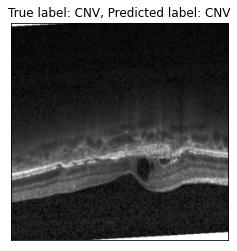

In [132]:
# Perform forward propagation in a batch of data and display the results.
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of data from the dataloader
    images, labels = next(iter(testing_data_loader))
    images, labels = images.to(device), labels.to(device)

    # Pass the inputs through the model to get the predicted outputs
    outputs = model(images)

    # Convert the predicted outputs to labels
    _, predicted = torch.max(outputs, 1)

    # Get the first image and label from the batch
    image = images[0].cpu()
    true_label = labels[0].cpu()
    predicted_label = predicted[0].cpu()

    # Display the image with the true and predicted labels
    fig, ax = matplotlib.pyplot.subplots(figsize=(8, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(((image * norm_factors[1] + norm_factors[0]).repeat(3, 1, 1)).permute(1, 2, 0))
    ax.set_title(f'True label: {classes[true_label]}, Predicted label: {classes[predicted_label]}')